In [1]:
import os 
import xarray as xr
import numpy as np
import glob
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
import itertools
from numpy.lib.stride_tricks import sliding_window_view
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from scipy.stats import pearsonr
import utils_results as ut


In [2]:
# cluster_variables = ['abs_vo600', 'abs_vo850', 'mpi', 'msl', 'r400', 'r600', 'r700', 'r850', 'ssta20', 'ssta30', 'sst', 'vo600', 'vo850', 'vws600-250', 'vws850-200', 'vws_u600-250', 'vws_u850-200', 'vws_v600-250', 'vws_v850-200', 'mgu850', 'mgu600', 'mgv850', 'mgv600', 'zgu850', 'zgu600', 'zgv850', 'zgc600', 'w']
# len(cluster_variables)

In [ ]:
n_clusters = 6
n_vars = 14
n_idxs = 10
results_folder = f'test_nc{n_clusters}_nv{n_vars}_nd{n_idxs}'
basin = 'GLB'
model_kind = 'LinReg'
n_folds = 5
start_year = 1980
end_year = 2021

# Set project directory and name of file containing the target variable
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
target_file = 'target_1965-2022_2.5x2.5.csv'

# Set the paths to the files
experiment_filename = f'1965-2022_{n_clusters}clusters_{n_vars}vars_{n_idxs}idxs.csv'
sol_filename = f'{model_kind}_' + experiment_filename
predictor_file = 'predictors_' + experiment_filename
fs_dir = os.path.join(project_dir, 'FS_TCG')
output_dir = os.path.join(fs_dir, 'results', results_folder)
sol_path = os.path.join(output_dir, sol_filename)
# final_sol_path = os.path.join(output_dir, f'CRO_{sol_filename}')
data_dir = os.path.join(fs_dir, 'data', f'{basin}_{n_clusters}clusters')
predictors_path = os.path.join(data_dir, predictor_file)
target_path = os.path.join(data_dir, target_file)
results_figure_dir = os.path.join(output_dir, 'figures')
os.makedirs(results_figure_dir, exist_ok=True)

# Load the predictors and the target in a DataFrame
predictors_df = pd.read_csv(predictors_path, index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
target_df = pd.read_csv(target_path, index_col=0)
target_df.index = pd.to_datetime(target_df.index)

# Load the labels files and plot the clusters for each atmospheric variable
files_labels = os.listdir(data_dir)
files_labels = [file for file in files_labels if file.startswith('label')]
files_labels.sort()

# Load the solutione file in a DataFrame
sol_file_df = pd.read_csv(sol_path, sep=' ', header=0)

# Load the file containing the best solution information 
best_solution = pd.read_csv(os.path.join(output_dir, f'best_solution_{sol_filename}'), sep=',', header=None)
best_solution = best_solution.to_numpy().flatten()

# Find solutions with best performance both for Cross-Validation and Test metric
CVbest = sol_file_df['CV'].idxmin() # metric is mean squared error
Testbest = sol_file_df['Test'].idxmin()

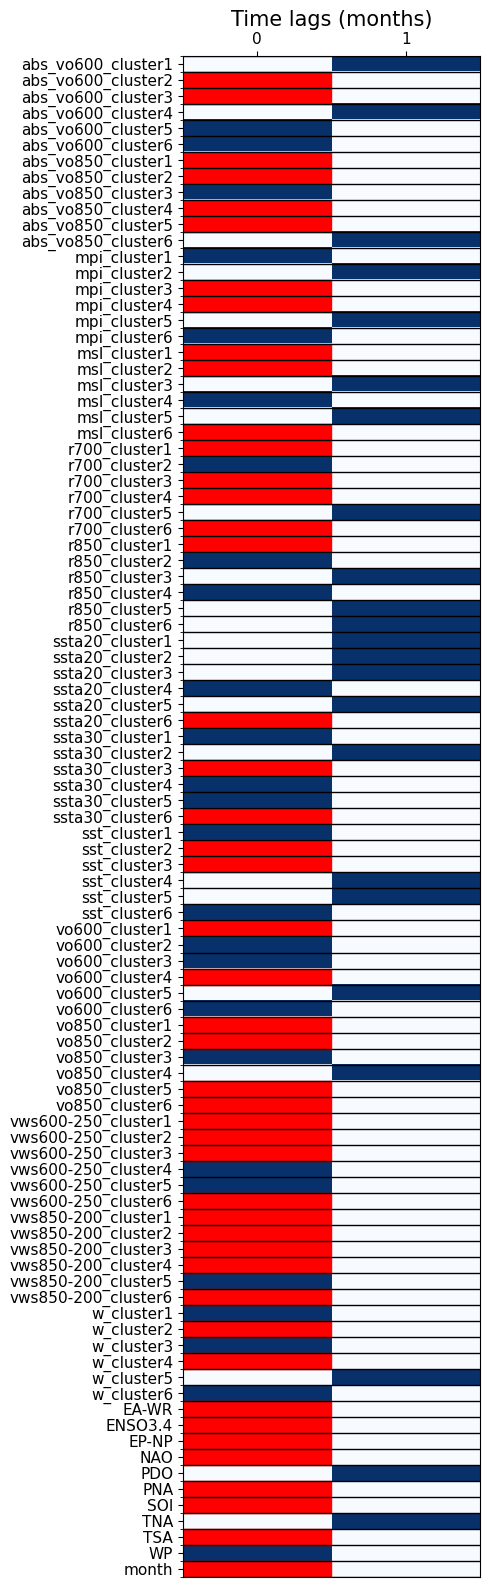

In [39]:
# Select the variables from the best solutions and plot it
column_names = predictors_df.columns.tolist()
final_sequence = best_solution[len(column_names):2*len(column_names)]
sequence_length = best_solution[:len(column_names)]
feat_sel = best_solution[2*len(column_names):]
n_rows = len(column_names)
n_cols = int(((sequence_length + final_sequence)*feat_sel).max())
board_best = ut.create_board(n_rows, n_cols, final_sequence, sequence_length, feat_sel)
fig_board = ut.plot_board(board_best, column_names, feat_sel)

In [5]:
variable_selection = feat_sel.astype(int)
time_sequences = sequence_length.astype(int)
time_lags = final_sequence.astype(int)
dataset_opt = target_df.copy()
label_selected_vars = []
for c, col in enumerate(predictors_df.columns):
    if variable_selection[c] == 0 or time_sequences[c] == 0:
        continue
    for j in range(time_sequences[c]):
        dataset_opt[str(col) +'_lag'+ str(time_lags[c]+j)] = predictors_df[col].shift(time_lags[c]+j)
        label_selected_vars.append(str(col) +'_lag'+ str(time_lags[c]+j))

In [6]:
variables_with_cluster = [var for var in label_selected_vars if 'cluster' in var]
variable_names = [var.split('_cluster')[0] for var in variables_with_cluster]
variable_names = list(set(variable_names))
variable_names.sort()
variable_names

['abs_vo600',
 'abs_vo850',
 'mpi',
 'msl',
 'r700',
 'r850',
 'sst',
 'ssta20',
 'ssta30',
 'vo600',
 'vo850',
 'vws600-250',
 'vws850-200',
 'w']